In [1]:
%matplotlib inline
from collections import defaultdict

import matplotlib.pylab as plt
from skimpy import skim
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import seaborn as sns

from tqdm import tqdm

from pathlib import Path


In [2]:

import tensorflow as tf
import tensorflow_probability as tfp

from bayesianquilts.models.logistic_regression import LogisticRegression
from bayesianquilts.metrics.classification import classification_metrics
from bayesianquilts.sampler import psis, nppsis

2024-02-07 21:27:46.948400: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-07 21:27:46.986846: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 21:27:46.986892: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 21:27:46.988218: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-07 21:27:46.994734: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-07 21:27:46.995190: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
print(tf.__version__, tfp.__version__)

2.15.0 0.23.0


# Load the dataset

Using the example from here: https://www.tensorflow.org/guide/core/logistic_regression_core

In [4]:
from ucimlrepo import fetch_ucirepo 


In [15]:
dataset = fetch_ucirepo(id=45) 
X_ = dataset.data.features
y_ = dataset.data.targets
y_ = (y_>= 1).astype(int)

In [17]:
X_

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0


In [23]:
use_saved = False




# data (as pandas dataframes) 
batch_size=101


X_ = X_.fillna(0)

X_scaled = (X_ - X_.mean())/X_.std()
X_scaled = X_scaled.fillna(0)
n = X_scaled.shape[0]
p = X_scaled.shape[1]

print((n, p))


(303, 13)


In [24]:
X_.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

In [25]:
tfdata = tf.data.Dataset.from_tensor_slices({'X': X_scaled, 'y':y_})

def data_factory_factory(batch_size=batch_size, repeat=False, shuffle=False, omit_outlier=False):
    tfdata_ = tfdata
    def data_factory(batch_size=batch_size):
        if shuffle:
            out = tfdata_.shuffle(batch_size*10)
        else:
            out = tfdata_
        
        if repeat:
            out = out.repeat()
        return out.batch(batch_size)
    return data_factory

Instantiate the model object

In [26]:
if not use_saved:
    lr_model = LogisticRegression(dim_regressors=p, global_horseshoe_scale=1.)
        
else:
    import dill as pickle
    import gzip
    with gzip.open("breast.gz", 'rb') as f:
        lr_model = pickle.load(f)

Set up Bayesian minibatch ADVI inference

In [28]:
if not use_saved:

    losses = lr_model.fit(
        data_factory_factory(shuffle=True, repeat=True, omit_outlier=True),
        dataset_size=n,
        batches_per_step=3,
        check_every=int(n/batch_size)*20,
        batch_size=batch_size,
        num_steps=6000,
        max_decay_steps=20,
        max_plateau_epochs=20,
        sample_size=32,
        learning_rate=0.0005)
        




Running optimization for 6000 steps of 3 accumulated batches, checking every 60 steps
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-1


  0%|          | 0/6000 [00:00<?, ?it/s]

  1%|          | 57/6000 [00:02<02:56, 33.75it/s] 

Step 60: average-batch loss:75.06334932206681 rel loss: 1.3322080736224545e+306
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-2


  2%|▏         | 117/6000 [00:04<02:47, 35.06it/s]

Step 120: average-batch loss:74.79209384227879 rel loss: 0.0036267934998590453
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-3


  3%|▎         | 177/6000 [00:06<02:46, 34.96it/s]

Step 180: average-batch loss:73.38045780279317 rel loss: 0.019237220395644378
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-4


  4%|▍         | 237/6000 [00:07<02:44, 35.04it/s]

Step 240: average-batch loss:70.7134566146856 rel loss: 0.03771561051865905
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-5


  5%|▍         | 297/6000 [00:09<02:42, 35.11it/s]

Step 300: average-batch loss:70.54970416439342 rel loss: 0.002321093365758228
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-6


  6%|▌         | 357/6000 [00:11<02:41, 34.98it/s]

Step 360: average-batch loss:67.89089379383883 rel loss: 0.03916298964377282
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-7


  7%|▋         | 417/6000 [00:13<02:39, 35.06it/s]

Step 420: average-batch loss:66.95772098620485 rel loss: 0.01393674685890578
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-8


  8%|▊         | 477/6000 [00:14<02:36, 35.24it/s]

Step 480: average-batch loss:66.43117118532844 rel loss: 0.007926245939687725
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-9


  9%|▉         | 537/6000 [00:16<02:35, 35.10it/s]

Step 540: average-batch loss:65.55118626789555 rel loss: 0.013424393478350756
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-10


 10%|▉         | 597/6000 [00:18<02:35, 34.66it/s]

Step 600: average-batch loss:64.8246994128428 rel loss: 0.011206945217378245
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-11


 11%|█         | 657/6000 [00:20<02:33, 34.90it/s]

Step 660: average-batch loss:63.55794726029395 rel loss: 0.01993066496249513
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-12


 12%|█▏        | 717/6000 [00:21<02:30, 35.11it/s]

Step 720: average-batch loss:62.62961742045011 rel loss: 0.014822537292726905
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-13


 13%|█▎        | 777/6000 [00:23<02:27, 35.32it/s]

Step 780: average-batch loss:62.364661406705316 rel loss: 0.00424849598744564
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-14


 14%|█▍        | 837/6000 [00:25<02:28, 34.87it/s]

Step 840: average-batch loss:62.23532745898503 rel loss: 0.0020781436042980332
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-15


 15%|█▍        | 897/6000 [00:26<02:25, 35.13it/s]

Step 900: average-batch loss:62.96883593289275 rel loss: 0.011648753912005531
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 16%|█▌        | 957/6000 [00:28<02:23, 35.23it/s]

Step 960: average-batch loss:62.22414199899659 rel loss: 0.0001797607749837665
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-16


 17%|█▋        | 1017/6000 [00:30<02:23, 34.78it/s]

Step 1020: average-batch loss:60.79954764348961 rel loss: 0.02343100254397251
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-17


 18%|█▊        | 1077/6000 [00:32<02:18, 35.44it/s]

Step 1080: average-batch loss:59.83669626098813 rel loss: 0.01609131925168195
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-18


 19%|█▉        | 1137/6000 [00:33<02:18, 35.19it/s]

Step 1140: average-batch loss:59.79827070895643 rel loss: 0.0006425863419816532
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-19


 20%|█▉        | 1197/6000 [00:35<02:17, 34.91it/s]

Step 1200: average-batch loss:59.548260507176586 rel loss: 0.004198446766546833
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-20


 21%|██        | 1257/6000 [00:37<02:14, 35.21it/s]

Step 1260: average-batch loss:59.664690694427286 rel loss: 0.0019514085449130517
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 22%|██▏       | 1317/6000 [00:38<02:13, 34.96it/s]

Step 1320: average-batch loss:58.66942704525125 rel loss: 0.014979411018408311
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-21


 23%|██▎       | 1377/6000 [00:40<02:24, 32.10it/s]

Step 1380: average-batch loss:59.89103881998323 rel loss: 0.02039723803094863
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 24%|██▍       | 1437/6000 [00:43<03:43, 20.46it/s]

Step 1440: average-batch loss:59.22553736130917 rel loss: 0.009389704861018627
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 25%|██▍       | 1497/6000 [00:46<03:18, 22.69it/s]

Step 1500: average-batch loss:59.176374922689966 rel loss: 0.008566727483746905
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 26%|██▌       | 1558/6000 [00:49<03:16, 22.64it/s]

Step 1560: average-batch loss:59.196713840082225 rel loss: 0.008907365977365302
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 27%|██▋       | 1619/6000 [00:52<03:05, 23.59it/s]

Step 1620: average-batch loss:58.98859238395335 rel loss: 0.005410628153739921
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 28%|██▊       | 1676/6000 [00:54<02:04, 34.82it/s]

Step 1680: average-batch loss:59.04211884898064 rel loss: 0.0063123040127112595
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 29%|██▉       | 1736/6000 [00:56<02:00, 35.37it/s]

Step 1740: average-batch loss:57.3887466145261 rel loss: 0.022315880835093643
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-22


 30%|██▉       | 1796/6000 [00:57<01:59, 35.27it/s]

Step 1800: average-batch loss:57.62866210218507 rel loss: 0.004163127841377952
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 31%|███       | 1856/6000 [00:59<01:58, 35.08it/s]

Step 1860: average-batch loss:57.22629142560478 rel loss: 0.0028388208439562353
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-23


 32%|███▏      | 1916/6000 [01:01<01:55, 35.26it/s]

Step 1920: average-batch loss:57.111075578387094 rel loss: 0.0020173993581953393
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-24


 33%|███▎      | 1976/6000 [01:02<01:59, 33.55it/s]

Step 1980: average-batch loss:57.049894505548586 rel loss: 0.0010724134263308351
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-25


 34%|███▍      | 2036/6000 [01:04<01:52, 35.21it/s]

Step 2040: average-batch loss:57.31229321975775 rel loss: 0.0045784019355676955
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 35%|███▍      | 2096/6000 [01:06<01:51, 35.08it/s]

Step 2100: average-batch loss:57.30892363873883 rel loss: 0.004519874336204627
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 36%|███▌      | 2156/6000 [01:08<01:48, 35.34it/s]

Step 2160: average-batch loss:56.83833461505909 rel loss: 0.003722133871836644
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-26


 37%|███▋      | 2216/6000 [01:09<01:47, 35.22it/s]

Step 2220: average-batch loss:56.38839536209287 rel loss: 0.00797928811552402
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-27


 38%|███▊      | 2276/6000 [01:11<01:45, 35.22it/s]

Step 2280: average-batch loss:56.126893218187924 rel loss: 0.004659123798076334
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-28


 39%|███▉      | 2336/6000 [01:13<01:47, 34.06it/s]

Step 2340: average-batch loss:56.50115381343162 rel loss: 0.006623946060986938
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 40%|███▉      | 2396/6000 [01:15<01:42, 35.06it/s]

Step 2400: average-batch loss:55.84685857518472 rel loss: 0.005014331157520775
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-29


 41%|████      | 2456/6000 [01:16<01:39, 35.60it/s]

Step 2460: average-batch loss:56.15477143785972 rel loss: 0.005483289394486033
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 42%|████▏     | 2516/6000 [01:18<01:38, 35.31it/s]

Step 2520: average-batch loss:55.92732242778124 rel loss: 0.0014387217035184512
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 43%|████▎     | 2576/6000 [01:20<01:38, 34.82it/s]

Step 2580: average-batch loss:56.23701649668559 rel loss: 0.006937742181324055
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 44%|████▍     | 2636/6000 [01:21<01:36, 34.95it/s]

Step 2640: average-batch loss:55.33628711934298 rel loss: 0.009226702448261475
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-30


 45%|████▍     | 2696/6000 [01:23<01:33, 35.47it/s]

Step 2700: average-batch loss:54.83655930187495 rel loss: 0.009113041077523277
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-31


 46%|████▌     | 2756/6000 [01:25<01:31, 35.33it/s]

Step 2760: average-batch loss:54.854458883841026 rel loss: 0.0003263104281819802
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 47%|████▋     | 2816/6000 [01:26<01:30, 35.33it/s]

Step 2820: average-batch loss:55.038858818414475 rel loss: 0.0036755761453368292
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 48%|████▊     | 2876/6000 [01:28<01:28, 35.22it/s]

Step 2880: average-batch loss:55.62635785464507 rel loss: 0.014198279075432408
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 49%|████▉     | 2936/6000 [01:30<01:26, 35.25it/s]

Step 2940: average-batch loss:54.68183128179251 rel loss: 0.002829605674416348
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-32


 50%|████▉     | 2996/6000 [01:32<01:25, 35.26it/s]

Step 3000: average-batch loss:54.88229270598418 rel loss: 0.0036525701516439734
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 51%|█████     | 3056/6000 [01:33<01:24, 34.96it/s]

Step 3060: average-batch loss:54.684656289783796 rel loss: 5.1659975264606006e-05
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 52%|█████▏    | 3116/6000 [01:35<01:26, 33.17it/s]

Step 3120: average-batch loss:54.49859770323428 rel loss: 0.003362170519616067
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-33


 53%|█████▎    | 3176/6000 [01:37<01:20, 35.03it/s]

Step 3180: average-batch loss:54.154421786943 rel loss: 0.0063554536256588325
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-34


 54%|█████▍    | 3236/6000 [01:39<01:18, 35.38it/s]

Step 3240: average-batch loss:54.13257609701859 rel loss: 0.0004035590304302511
Saved a checkpoint: /tmp/tfcheckpoints/ccf367fd-da3a-4ee1-935c-2eeed82335ae/ccf367fd-da3a-4ee1-935c-2eeed82335ae-35


 55%|█████▍    | 3296/6000 [01:40<01:17, 34.97it/s]

Step 3300: average-batch loss:54.279866197675496 rel loss: 0.0027135310194115916


 55%|█████▌    | 3300/6000 [01:40<01:16, 35.09it/s]

Terminating because the loss converged


 55%|█████▌    | 3300/6000 [01:40<01:22, 32.68it/s]


3it [00:00, 12.57it/s]


(0.0, 1.0)

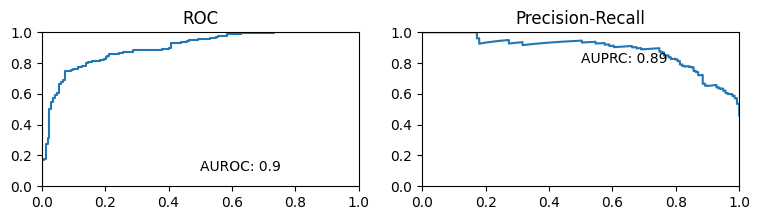

In [47]:
def prediction_fn(data):
    params = lr_model.sample(128)
    pred = lr_model.predictive_distribution(data, **params)["logits"]
    return tf.reduce_mean(pred, axis=0)

bench = classification_metrics(
    data_factory=data_factory_factory(),
    prediction_fn=prediction_fn,
    outcome_label='y',
    by_vars=[]
)

fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench['auroc']['fpr'], bench['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench['auprc']['recall'], bench['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

In [30]:
test_batch = next(iter(data_factory_factory()()))
param_test = lr_model.sample(128)


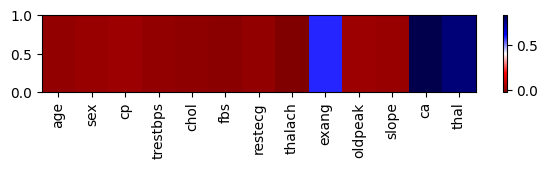

In [31]:
beta = tf.reduce_mean(param_test['beta__'], axis=0)
fig, ax = plt.subplots(1, 1, figsize=(7, 1 ))
im = ax.pcolormesh(beta, cmap='seismic_r')
_ = ax.set_xticks(0.5 + np.arange(len(X_.columns)), X_.columns, rotation=90)
plt.colorbar(im)

In [32]:
def entropy(probs):
    return -tf.math.xlogy(probs, probs)


def adaptive_is_loo(self, data, params, hbar=1.0, variational=True):
    """_summary_

    Args:
        data (_type_): _description_
        params (_type_): _description_
        hbar (float, optional): _description_. Defaults to 1.0.
        variational (bool, optional):
            Should we trust the variational approximation?
            If False, assumes that one is passing in all the data at once in a single batch.
            Defaults to True.

    Returns:
        _type_: _description_
    """

    # scaled (theta - bar(theta))/Sigma
    beta = params["beta__"]
    intercept = params["intercept__"]
    X = tf.cast(data["X"], self.dtype)
    y = tf.cast(data["y"], self.dtype)[:, 0]
    mu = tf.reduce_sum(beta * X, axis=-1) + intercept[..., 0]
    sigma = tf.math.sigmoid(mu)
    ell = y * (sigma) + (1 - y) * (1 - sigma)
    log_ell = tf.math.xlogy(y, sigma) + tf.math.xlogy(1 - y, 1 - sigma)
    log_ell_prime = y * (1 - sigma) - (1 - y) * sigma
    log_ell_doubleprime = -sigma * (1 - sigma)

    """
    sigma.shape is samples x datapoints
    """

    # compute # \nabla\log\pi(\btheta|\calD)
    if variational:
        # \nabla\log\pi = -\Sigma^{-1}(theta - \bar{\theta})
        grad_log_pi = tf.concat(
            [
                -(intercept - self.surrogate_distribution.model["intercept__"].mean())
                / self.surrogate_distribution.model["intercept__"].variance(),
                -(beta - self.surrogate_distribution.model["beta__"].mean())
                / self.surrogate_distribution.model["beta__"].variance(),
            ],
            axis=-1,
        )
        intercept_sd = (
            self.surrogate_distribution.model["intercept__"].variance() ** 0.5
        )
        beta_sd = self.surrogate_distribution.model["beta__"].variance() ** 0.5

        log_pi = self.surrogate_distribution.model["beta__"].log_prob(
            params["beta__"]
        ) + self.surrogate_distribution.model["intercept__"].log_prob(
            params["intercept__"]
        )
        log_pi -= tf.reduce_max(log_pi, axis=0)
        # log_pi.shape: [samples]
    else:
        """
        Recall Bayes rule:
        \log pi(\btheta|\calD) = \sum_i\log ell_i(\btheta) + \log\pi(\btheta) + const

        so
        \nabla\log\pi(\btheta|\calD) = \sum_i (ell_i)'x + grad\log\pi(\btheta)

        """
        log_pi = tf.reduce_sum(log_ell, axis=1, keepdims=True)[:, 0]
        log_pi += self.prior_distribution.log_prob(
            {
                "regression_model": {
                    k: tf.cast(params[k], self.dtype) for k in self.regression_var_list
                },
                "intercept_model": {
                    k: tf.cast(params[k], self.dtype) for k in self.intercept_var_list
                },
            }
        )
        # pi \propto
        grad_log_pi = tf.reduce_sum(
            log_ell[..., tf.newaxis] * X, axis=1, keepdims=True
        )  # TODO NEED PRIOR TERM

        prior_intercept_sd = (
            self.prior_distribution.model["intercept_model"]
            .model["intercept__"]
            .variance()
            ** 0.5
        )
        prior_beta_sd = params["global_scale"]

        intercept_sd = tf.math.reduce_std(intercept, 0, keepdims=True)
        beta_sd = tf.math.reduce_std(beta, 0, keepdims=True)

    # log-likelihood descent

    def T_ll():
        Q_beta = -log_ell_prime[..., tf.newaxis] * X
        Q_intercept = -log_ell_prime[..., tf.newaxis]

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized
        logJ = tf.math.log1p(
            tf.math.abs(
                h
                * (1 + tf.math.reduce_sum(X**2, -1, keepdims=True))[tf.newaxis, :, :]
                * (sigma * (1 - sigma))[..., tf.newaxis]
            )[..., 0]
        )
        beta_ll = beta + h * Q_beta
        intercept_ll = intercept + h * Q_intercept
        return beta_ll, intercept_ll, logJ

    def T_kl():

        Q_beta = ((-1) ** y * tf.math.exp(log_pi[..., tf.newaxis] + mu * (1 - 2 * y)))[
            ..., tf.newaxis
        ] * data["X"]
        Q_intercept = (
            (-1) ** y * tf.math.exp(log_pi[..., tf.newaxis] + mu * (1 - 2 * y))
        )[..., tf.newaxis]

        dQ = (
            (-1) ** y[tf.newaxis, :]
            * tf.math.exp(log_pi[..., tf.newaxis] + mu * (1 - 2 * y[tf.newaxis, :]))
            * (
                grad_log_pi[..., 0]
                + (1 - 2 * y)[tf.newaxis, :]
                + tf.reduce_sum(
                    X * (grad_log_pi[..., 1:] + (1 - 2 * y)[:, tf.newaxis] * X), axis=-1
                )
            )
        )

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized

        intercept_kl = intercept + h * Q_intercept
        beta_kl = beta + h * Q_beta

        logJ = tf.math.log1p(tf.math.abs(h[..., 0] * dQ))
        return beta_kl, intercept_kl, logJ

    # variance descent -(log ell)'/l

    def T_I():
        Q = tf.zeros_like(log_ell)
        return (
            beta + Q[..., tf.newaxis],
            intercept + Q[..., tf.newaxis],
            tf.zeros_like(Q),
        )

    def T_var():

        Q_beta = (
            (-1) ** y * tf.math.exp(log_pi[..., tf.newaxis] + 2 * mu * (1 - 2 * y))
        )[..., tf.newaxis] * data["X"]
        Q_intercept = (
            (-1) ** y * tf.math.exp(log_pi[..., tf.newaxis] + 2 * mu * (1 - 2 * y))
        )[..., tf.newaxis]

        dQ = (
            (-1) ** y[tf.newaxis, :]
            * tf.math.exp(log_pi[..., tf.newaxis] + 2 * mu * (1 - 2 * y[tf.newaxis, :]))
            * (
                grad_log_pi[..., 0]
                + (1 - 2 * y)[tf.newaxis, :]
                + tf.reduce_sum(
                    X * (grad_log_pi[..., 1:] + 2 * (1 - 2 * y)[:, tf.newaxis] * X),
                    axis=-1,
                )
            )
        )

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized

        intercept_kl = intercept + h * Q_intercept
        beta_kl = beta + h * Q_beta

        logJ = tf.math.log1p(tf.math.abs(h[..., 0] * dQ))
        return beta_kl, intercept_kl, logJ

    def IS(Q):
        beta_new, intercept_new, logJ = Q()
        mu_new = tf.reduce_sum(beta_new * X, axis=-1) + intercept_new[..., 0]
        sigma_new = tf.math.sigmoid(mu_new)
        ell_new = y * (sigma_new) + (1 - y) * (1 - sigma_new)
        log_ell_new = tf.math.xlogy(y, sigma_new) + tf.math.xlogy(1 - y, 1 - sigma_new)
        transformed = params.copy()
        transformed["beta__"] = beta_new[..., tf.newaxis, :]
        transformed["intercept__"] = intercept_new[..., tf.newaxis, :]
        transformed["global_scale"] = transformed["global_scale"][..., tf.newaxis, :]
        transformed["global_scale_aux"] = transformed["global_scale_aux"][
            ..., tf.newaxis, :
        ]

        if variational:
            # We trust the variational approximation, so \hat{pi} = pi
            # N_samples x N_data
            delta_log_pi = (
                self.surrogate_distribution.log_prob(transformed)
                - log_pi[:, tf.newaxis]
            )
            delta_log_pi = delta_log_pi - tf.reduce_max(
                delta_log_pi, axis=0, keepdims=True
            )
            pass
        else:
            # we don't trust the variational approximation
            # Need to compute log_pi directly by summing over the likelihood

            ell_cross = (
                tf.reduce_sum(beta_new[..., tf.newaxis, :] * data["X"], -1)
                + intercept_new
            )
            ell_cross = tf.reduce_sum(
                ell_cross, -1
            )  # this is the likelihood portion of pi(T(theta))

            log_pi_new = self.prior_distribution.log_prob(
                {
                    "regression_model": {
                        k: tf.cast(transformed[k], self.dtype)
                        for k in self.regression_var_list
                    },
                    "intercept_model": {
                        k: tf.cast(transformed[k], self.dtype)
                        for k in self.intercept_var_list
                    },
                }
            )[:, tf.newaxis]
            log_pi_new += ell_cross
            log_pi_old = self.surrogate_distribution.log_prob(params)
            # Incorporate the prior
            delta_log_pi = log_pi_new - log_pi_old[:, tf.newaxis]
            delta_log_pi = delta_log_pi - tf.reduce_max(
                delta_log_pi, axis=0, keepdims=True
            )

        log_eta_weights = delta_log_pi - log_ell_new + logJ
        psis_weights, khat = nppsis.psislw(log_eta_weights)
        
        eta_weights = tf.math.exp(log_eta_weights)
        eta_weights = eta_weights / tf.reduce_sum(eta_weights, axis=0, keepdims=True)

        psis_weights = tf.math.exp(psis_weights)
        psis_weights = psis_weights / tf.math.reduce_sum(
            psis_weights, axis=0, keepdims=True
        )

        weight_entropy = self.entropy(eta_weights)
        psis_entropy = self.entropy(psis_weights)

        p_loo_new = tf.reduce_sum(sigma_new * eta_weights, axis=0)
        p_loo_psis = tf.reduce_sum(sigma_new * psis_weights, axis=0)
        p_loo_sd = tf.math.reduce_std(sigma_new * eta_weights, axis=0)
        ll_loo_new = tf.reduce_sum(eta_weights * ell_new, axis=0)
        ll_loo_psis = tf.reduce_sum(psis_weights * ell_new, axis=0)
        ll_loo_sd = tf.math.reduce_std(eta_weights * ell_new, axis=0)
        return (
            eta_weights,
            psis_weights,
            p_loo_new,
            p_loo_sd,
            ll_loo_new,
            ll_loo_sd,
            weight_entropy,
            khat,
            p_loo_psis,
            ll_loo_psis,
        )
    (
        eta_I,
        eta_I_psis,
        p_loo_I,
        p_loo_I_sd,
        ll_loo_I,
        ll_loo_I_sd,
        S_I,
        k_I,
        p_psis_I,
        ll_psis_I,
    ) = IS(T_I)
    (
        eta_ll,
        eta_ll_psis,
        p_loo_ll,
        p_loo_ll_sd,
        ll_loo_ll,
        ll_loo_ll_sd,
        S_ll,
        k_ll,
        p_psis_ll,
        ll_psis_ll,
    ) = IS(T_ll)

    (
        eta_kl,
        eta_kl_psis,
        p_loo_kl,
        p_loo_kl_sd,
        ll_loo_kl,
        ll_loo_kl_sd,
        S_kl,
        k_kl,
        p_psis_kl,
        ll_psis_kl,
    ) = IS(T_kl)

    (
        eta_var,
        eta_var_psis,
        p_loo_var,
        p_loo_var_sd,
        ll_loo_var,
        ll_loo_var_sd,
        S_var,
        k_var,
        p_psis_var,
        ll_psis_var,
    ) = IS(T_var)

    # kl descent

    return {
        "I": {
            "p_loo": p_loo_I,
            "p_loo_sd": p_loo_I_sd,
            "ll_loo": ll_loo_I,
            "ll_loo_sd": ll_loo_I_sd,
            "S": S_I,
            "khat": k_I,
            "p_psis": p_psis_I,
            "ll_psis": ll_psis_I,
        },
        "KL": {
            "p_loo": p_loo_kl,
            "p_loo_sd": p_loo_kl_sd,
            "ll_loo": ll_loo_kl,
            "ll_loo_sd": ll_loo_kl_sd,
            "S": S_kl,
            "khat": k_kl,
            "p_psis": p_psis_kl,
            "ll_psis": ll_psis_kl,
        },
        "LL": {
            "p_loo": p_loo_kl,
            "p_loo_sd": p_loo_kl_sd,
            "ll_loo": ll_loo_kl,
            "ll_loo_sd": ll_loo_kl_sd,
            "S": S_ll,
            "khat": k_ll,
            "p_psis": p_psis_ll,
            "ll_psis": ll_psis_ll,
        },
        "Var": {
            "p_loo": p_loo_var,
            "p_loo_sd": p_loo_var_sd,
            "ll_loo": ll_loo_var,
            "ll_loo_sd": ll_loo_var_sd,
            "S": S_var,
            "khat": k_var,
            "p_psis": p_psis_var,
            "ll_psis": ll_psis_var,
        },
    }


param_test = lr_model.sample(256)

loo = adaptive_is_loo(lr_model, test_batch, param_test, 1., variational=True)

# loo = adaptive_is_loo(lr_model, test_batch, param_test, 0.01, variational=False)


for T in ["I", "LL", "KL", "Var"]:
    print(
        f"{T}: {np.sqrt(np.sum(loo[T]['p_loo_sd']**2))} entropy: {np.sqrt(np.sum(loo[T]['S']))} khat>0.5: {np.sum(loo[T]['khat']>0.5)}"
    )

I: 0.02148933878272433 entropy: 22.513937523103102 khat>0.5: 0
LL: 0.022279770050883 entropy: 20.290901768615395 khat>0.5: 53
KL: 0.022279770050883 entropy: 22.463941149054655 khat>0.5: 0
Var: 0.022120669934506572 entropy: 22.467715795648527 khat>0.5: 0


In [33]:
loo['I']['khat']

array([-0.48427683, -0.73744406, -0.78117376, -0.73871935, -0.68327906,
       -0.75305132, -0.56016918, -0.46529836, -0.58279742, -0.62030266,
       -0.54911087, -0.64939555, -0.7336691 , -0.58068557, -0.46488283,
       -0.65928469, -0.48981667, -0.62542035, -0.72367683, -0.75801403,
       -0.67487048, -0.66984341, -0.57729798, -0.71357513, -0.80002747,
       -0.70300741, -0.71388521, -0.61282841, -0.62847089, -0.60910218,
       -0.50272285, -0.71719391, -0.58468133, -0.50035422, -0.55513113,
       -0.6447148 , -0.61678779, -0.71154962, -0.77842292, -0.45560379,
       -0.76187875, -0.38823596, -0.43379323, -0.77134038, -0.26431606,
       -0.65459364, -0.68294602, -0.43887202, -0.4223452 , -0.76133038,
       -0.54267697, -0.44388688, -0.552471  , -0.65602922, -0.71806603,
       -0.75957719, -0.67853191, -0.53893035, -0.63366009, -0.53161725,
       -0.57105776, -0.56276527, -0.74156866, -0.70065879, -0.62723503,
       -0.78162952, -0.30367064, -0.33011402, -0.62757003, -0.42

# Compute LOO AU ROC/PRC

In [34]:
step_size = 0.2
def prediction_fn_stepaway(data):
    params = lr_model.sample(100)
    loo = adaptive_is_loo(lr_model, data, params, step_size)
    return loo["KL"]['p_psis']

def prediction_fn_loo(data):
    params = lr_model.sample(100)
    pred = adaptive_is_loo(lr_model, data, params, step_size)["I"]['p_psis']
    return pred



In [35]:
bench_stepaway_loo = classification_metrics(
    data_factory=data_factory_factory(batch_size=2000),
    prediction_fn=prediction_fn_stepaway,
    outcome_label='y',
    by_vars=[]
)

bench_loo = classification_metrics(
    data_factory=data_factory_factory(batch_size=2000),
    prediction_fn=prediction_fn_loo,
    outcome_label='y',
    by_vars=[]
)





1it [00:00,  1.50it/s]


1it [00:00,  1.52it/s]


Step-away LOO

(0.0, 1.0)

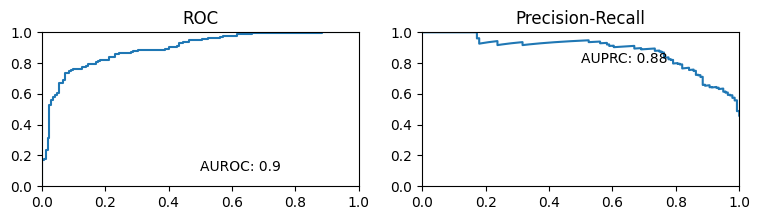

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench_stepaway_loo['auroc']['fpr'], bench_stepaway_loo['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench_stepaway_loo['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench_stepaway_loo['auprc']['recall'], bench_stepaway_loo['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench_stepaway_loo['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

LOO w/o stepaway

(0.0, 1.0)

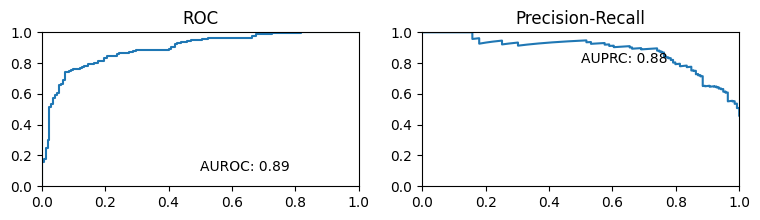

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench_loo['auroc']['fpr'], bench_loo['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench_loo['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench_loo['auprc']['recall'], bench_loo['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench_loo['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

Training data metrics

In [39]:
params = lr_model.sample(200)
loo_out = []
for batch in tqdm(iter(data_factory_factory(batch_size=1000, repeat=False)())):
    loo_out += [adaptive_is_loo(lr_model, batch, params, 0.5, variational=True)]



1it [00:00,  1.46it/s]


In [40]:
loo_out[0].keys()

dict_keys(['I', 'KL', 'LL', 'Var'])

In [41]:
khat = {}
p_loo = {}
for method in ["I", "LL", "KL", "Var"]:
    khat[method] = np.concatenate([out[method]["khat"] for out in loo_out], axis=0)
    p_loo[method] = np.concatenate([out[method]["p_loo"] for out in loo_out], axis=0)

  5%|▍         | 286/6000 [34:29<11:28:58,  7.23s/it]


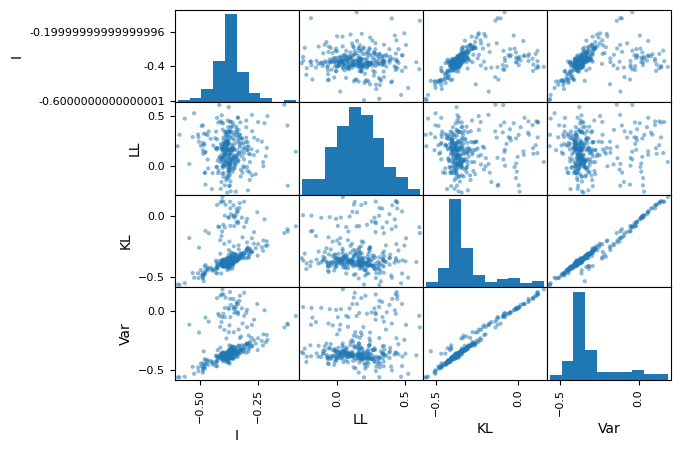

In [42]:
khat = pd.DataFrame(khat)
_ = pd.plotting.scatter_matrix(khat)


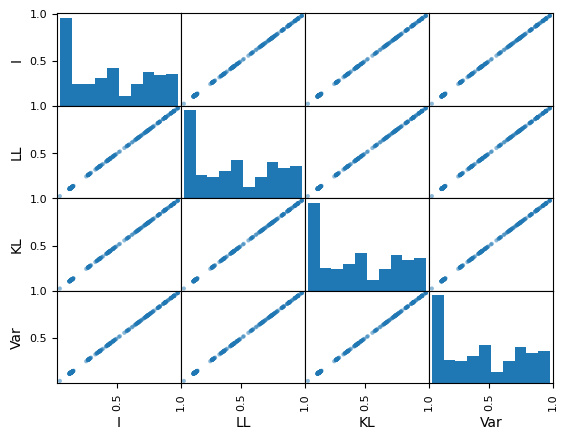

In [43]:
p_loo = pd.DataFrame(p_loo)
_ = pd.plotting.scatter_matrix(p_loo)

In [44]:
khat.describe()

,I,LL,KL,Var
count,303.000000,303.000000,303.000000,303.000000
mean,-0.371992,0.154084,-0.311817,-0.299859
std,0.066388,0.169436,0.145745,0.157823
min,-0.595574,-0.260121,-0.564184,-0.563193
25%,-0.399431,0.037983,-0.396010,-0.390572
50%,-0.376006,0.158793,-0.362918,-0.359878
75%,-0.343692,0.268142,-0.288912,-0.280363
max,-0.088568,0.607838,0.155784,0.185033


In [45]:
khat[khat.I > 0.5]

,I,LL,KL,Var


In [46]:
(khat>0.5).describe()

,I,LL,KL,Var
count,303,303,303,303
unique,1,2,1,1
top,False,False,False,False
freq,303,297,303,303
